In [1]:
import requests
import pandas as pd

API_KEY = 'QC6PHJMTIZHC8S6B'  # Replace with your actual AlphaVantage API key
SYMBOL = 'COST'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={SYMBOL}&outputsize=full&apikey={API_KEY}'

response = requests.get(url)
data = response.json()

if 'Time Series (Daily)' in data:
    print("Data fetched successfully.")
else:
    print("Failed to fetch data. Check the API key and symbol.")
    exit()

time_series_data = data['Time Series (Daily)']

# Initialize an empty DataFrame with the desired columns
df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume'])

# Create a list to hold row data before converting it to a DataFrame
rows_list = []

for date, daily_data in time_series_data.items():
    row = {
        'Date': date,
        'Open': daily_data['1. open'],
        'High': daily_data['2. high'],
        'Low': daily_data['3. low'],
        'Close': daily_data['4. close'],
        'Adjusted Close': daily_data['5. adjusted close'],
        'Volume': daily_data['6. volume']
    }
    rows_list.append(row)

# Convert the list of rows into a DataFrame
new_df = pd.DataFrame(rows_list)

# Convert the 'Date' column to datetime and set it as the index
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.set_index('Date', inplace=True)

# Sort the DataFrame by the index (Date)
new_df.sort_index(inplace=True)

# Save the DataFrame to a CSV file for future use
new_df.to_csv('data/' + SYMBOL + '.csv')


Data fetched successfully.


In [45]:
import pandas as pd

# Load the dataset
file_path = 'data/TSLA_stock_data.csv'
tesla_data = pd.read_csv(file_path)

# Convert the Date column to datetime type
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])

# Filter data to the last 5 years
tesla_data = tesla_data[tesla_data['Date'] >= (tesla_data['Date'].max() - pd.DateOffset(years=5))]

# Display the first few rows of the dataframe
print(tesla_data.head())

           Date    Open    High     Low   Close  Adjusted Close   Volume
2167 2019-02-07  313.30  314.70  303.00  307.51       20.500667  6520611
2168 2019-02-08  306.83  307.45  298.50  305.80       20.386667  5844212
2169 2019-02-11  311.60  318.60  310.50  312.84       20.856000  7129713
2170 2019-02-12  316.20  318.19  309.62  311.81       20.787333  5517570
2171 2019-02-13  312.35  312.75  305.57  308.17       20.544667  5141617


In [46]:
# Calculate daily returns as ROI
tesla_data['ROI'] = tesla_data['Close'].pct_change() * 100

# Drop the first NA value resulted from the pct_change() calculation
tesla_data.dropna(inplace=True)

# Display the first few rows of the modified dataframe
print(tesla_data.head())


           Date    Open    High     Low   Close  Adjusted Close   Volume  \
2168 2019-02-08  306.83  307.45  298.50  305.80       20.386667  5844212   
2169 2019-02-11  311.60  318.60  310.50  312.84       20.856000  7129713   
2170 2019-02-12  316.20  318.19  309.62  311.81       20.787333  5517570   
2171 2019-02-13  312.35  312.75  305.57  308.17       20.544667  5141617   
2172 2019-02-14  303.38  306.77  301.00  303.77       20.251333  5200832   

           ROI  
2168 -0.556079  
2169  2.302158  
2170 -0.329242  
2171 -1.167378  
2172 -1.427783  


In [47]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Apply ADF test on the ROI
adf_test(tesla_data['ROI'])


ADF Statistic: -34.549016
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


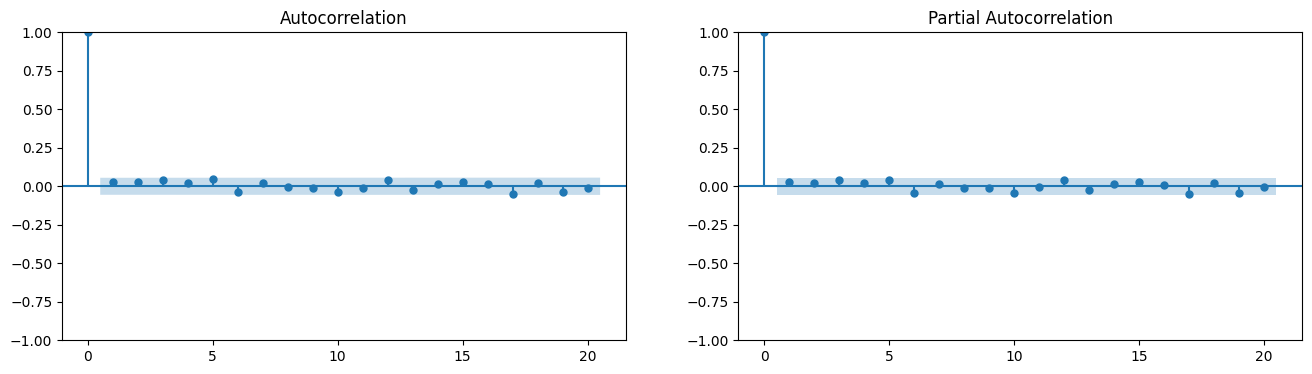

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(tesla_data['ROI'], lags=20, ax=ax1)
plot_pacf(tesla_data['ROI'], lags=20, ax=ax2)
plt.show()


In [59]:
from pmdarima import auto_arima

# Fit the AutoARIMA model
auto_model = auto_arima(tesla_data['Close'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Print out the summary of the model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13798.787, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13792.800, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13794.159, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13794.129, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13790.803, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13794.853, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6894.402
Date:                Wed, 14 Feb 2024   AIC                          13790.803
Time:                        19:38:14   BIC                          13795.940
Sample:                             0   HQIC                         13792.734
    

In [62]:
# Forecast the next 30 days with auto ARIMA
forecast = auto_model.predict(n_periods=30)

# Output the forecast to check
print(forecast)


1258    187.58
1259    187.58
1260    187.58
1261    187.58
1262    187.58
1263    187.58
1264    187.58
1265    187.58
1266    187.58
1267    187.58
1268    187.58
1269    187.58
1270    187.58
1271    187.58
1272    187.58
1273    187.58
1274    187.58
1275    187.58
1276    187.58
1277    187.58
1278    187.58
1279    187.58
1280    187.58
1281    187.58
1282    187.58
1283    187.58
1284    187.58
1285    187.58
1286    187.58
1287    187.58
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/var/folders/_d/n8yc91k902q2msrhx_h0b_bh0000gn/T/ipykernel_78692/4163358392.py:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=tesla_data['Date'].iloc[-1], periods=31, closed='right')[1:] # start the forecast from the next day


ValueError: x and y must have same first dimension, but have shapes (29,) and (30,)

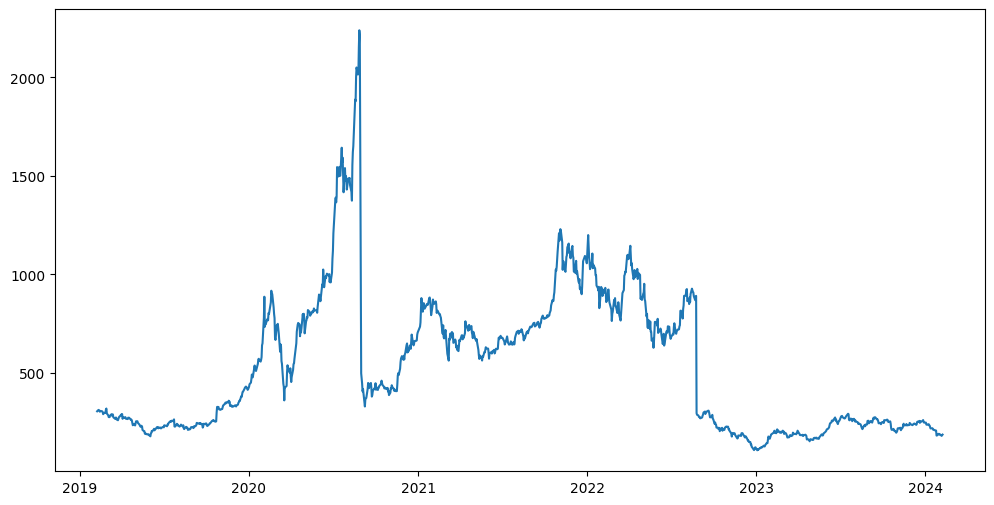

In [63]:
# Prepare the dates for the forecasted range
forecast_dates = pd.date_range(start=tesla_data['Date'].iloc[-1], periods=31, closed='right')[1:] # start the forecast from the next day

# Plot the historical stock prices for the last 5 years
plt.figure(figsize=(12, 6))
historical_dates = tesla_data['Date']
historical_prices = tesla_data['Close']
plt.plot(historical_dates, historical_prices, label='Historical Close Price')

# Plot the forecasted stock prices
plt.plot(forecast_dates, forecast, label='Forecasted Close Price', color='red')  # Directly plot the forecast

# Finalize the plot
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('TESLA Stock Price Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Update Once a Day

In [97]:
import requests

def get_company_overview(ticker):
    API_KEY = 'QC6PHJMTIZHC8S6B'  # Replace with your actual AlphaVantage API key
    url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={API_KEY}'
    
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError if the HTTP request returned an unsuccessful status code
        data = response.json()
        
        if 'Error Message' in data:
            return f"Error fetching data for {ticker}: {data['Error Message']}"
        
        # Extract the relevant information
        overview_data = {
            'MarketCapitalization': data.get('MarketCapitalization'),
            'PERatio': data.get('PERatio'),
            'EPS': data.get('EPS'),
            'ROE': data.get('ReturnOnEquityTTM'),
        }
        
        return overview_data
    
    except requests.exceptions.HTTPError as http_err:
        return f"HTTP error occurred: {http_err}"
    except Exception as err:
        return f"An error occurred: {err}"

# Example usage:
ticker = 'MSFT'  # Replace with the ticker you want to query
company_overview = get_company_overview(ticker)
print(company_overview)



{'MarketCapitalization': '3019136303000', 'PERatio': '36.74', 'EPS': '11.06', 'ROE': '0.392'}


### Store Once

In [96]:
import requests

def get_static_company_info(ticker):
    API_KEY = 'QC6PHJMTIZHC8S6B'  # Replace with your actual AlphaVantage API key
    url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={API_KEY}'
    
    response = requests.get(url)
    data = response.json()
    
    # Check if the response contains company information
    if not data:
        return f"No data found for ticker: {ticker}"

    # Extract the static information
    static_info = {
        'Symbol': ticker,
        'Name': data.get('Name'),
        'Exchange': data.get('Exchange'),
        'Currency': data.get('Currency'),
        'Country': data.get('Country'),
        'Address': data.get('Address'),
        'Description': data.get('Description'),
        'Sector': data.get('Sector'),
        'Industry': data.get('Industry')
    }
    
    return static_info

# Example usage:
ticker = 'ATVI'  # Replace with the ticker you want to query
company_static_info = get_static_company_info(ticker)
print(company_static_info)


No data found for ticker: ATVI


### Historical Stock Prices

In [77]:
import requests
import pandas as pd
from datetime import datetime
import os

def save_historical_stock_prices(ticker, api_key, data_directory='data'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&apikey={api_key}'

    response = requests.get(url)
    data = response.json()

    # Initialize an empty DataFrame
    prices_df = pd.DataFrame()

    if 'Time Series (Daily)' in data:
        # Parse and process historical stock prices
        time_series_data = data['Time Series (Daily)']
        rows_list = []  # Use a list to store the data temporarily

        for date, daily_data in time_series_data.items():
            # Only include data within the last 10 years
            if datetime.strptime(date, '%Y-%m-%d') >= datetime.now() - pd.DateOffset(years=10):
                rows_list.append({
                    'Date': date,
                    'Open': daily_data['1. open'],
                    'High': daily_data['2. high'],
                    'Low': daily_data['3. low'],
                    'Close': daily_data['4. close'],
                    'Adjusted Close': daily_data['5. adjusted close'],
                    'Volume': daily_data['6. volume']
                })

        # Convert the list of dictionaries to a DataFrame
        prices_df = pd.DataFrame(rows_list)

        # Convert the 'Date' column to datetime
        prices_df['Date'] = pd.to_datetime(prices_df['Date'])

        # Sort the DataFrame by the 'Date' column
        prices_df.sort_values('Date', inplace=True)

        # Check if the data directory exists, create it if not
        if not os.path.exists(data_directory):
            os.makedirs(data_directory)

        # Save the DataFrame to a CSV file in the specified directory
        csv_file_path = os.path.join(data_directory, f'{ticker}_historical_prices.csv')
        prices_df.to_csv(csv_file_path, index=False)

        return csv_file_path
    else:
        return "Failed to fetch data. Check the API key and symbol."

# Example usage:
api_key = 'QC6PHJMTIZHC8S6B'  # Replace with your actual AlphaVantage API key
ticker = 'AAPL'  # Replace with the ticker you want to query
historical_data_file_path = save_historical_stock_prices(ticker, api_key)
print(f"Historical data saved to: {historical_data_file_path}")

Historical data saved to: data/AAPL_historical_prices.csv


### Current stock price and volume of trade

In [98]:
import requests

def get_current_stock_price_and_volume(ticker, api_key):
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={ticker}&apikey={api_key}"
    
    response = requests.get(url)
    data = response.json()
    
    if "Global Quote" in data:
        global_quote = data["Global Quote"]
        current_price = global_quote.get("05. price")
        current_volume = global_quote.get("06. volume")
        
        return {
            "Current Price": current_price,
            "Current Volume": current_volume
        }
    else:
        return "Failed to fetch data. Check the API key and symbol."

# Example usage:
api_key = 'QC6PHJMTIZHC8S6B'  # Replace with your actual AlphaVantage API key
ticker = 'MSFT'  # Replace with the ticker you want to query
stock_info = get_current_stock_price_and_volume(ticker, api_key)
print(stock_info)


{'Current Price': '409.4900', 'Current Volume': '20401190'}


In [93]:
import pandas as pd

df = pd.read_csv("data/SP_500.csv")

tickers = df["Symbol"].unique()

tickers = tickers[:5]

tickers[0]



'MMM'